<a href="https://colab.research.google.com/github/DKwokAsc/MCMC-Final-Project/blob/main/David_Kwok_MCMC_with_Gerrychain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MCMC with GerryChain Assignment**
Completed by: David Kwok

Date of Completion: 10/03/2025

In [ ]:
# Install gerrychain packages
!pip install gerrychain[geo]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
# Install additional dependencies
# Credit to the GerryChain documentation & tutorial for providing many of the
# examples done in this demo
from gerrychain import Graph, Partition, MarkovChain, Election, metrics
from gerrychain.proposals import propose_random_flip,recom
from gerrychain.updaters import Tally, cut_edges
from gerrychain.constraints import single_flip_contiguous, contiguous, within_percent_of_ideal_population # used for validators
from gerrychain.accept import always_accept
from functools import partial

import matplotlib.pyplot as plt
import pandas
import numpy as np

import random
random.seed(42)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


#**Question 1 Partitions and Election**

Add files from canvas to data folder on the left sidebar with the folder. This zip file assumes that both PA-README.txt and PA_VTD.json already included in the files folder (not in the sample_data folder).

In [1]:
graph = Graph.from_json("./PA_VTDs.json")

# Create the election first after checking valid data
election = Election("SEN12",{"Dem":"USS12D", "Rep":"USS12R"})
# Partition segment
dem_partition = Partition(
    graph,
    assignment="538DEM_PL",
    updaters={
        "population": Tally("TOT_POP",alias="population"),
        "cut_edges": cut_edges,
        "SEN12": election
    }
)

rep_partition = Partition(
    graph,
    assignment="538GOP_PL",
    updaters={
        "population": Tally("TOT_POP",alias="population"),
        "cut_edges": cut_edges,
        "SEN12": election
    }
)

comp_partition = Partition(
    graph,
    assignment="538CPCT__1",
    updaters={
        "population": Tally("TOT_POP",alias="population"),
        "cut_edges": cut_edges,
        "SEN12": election
    }
)


# Prints output returns population info based on the plan chosen
def print_population(name, partition):
  print(f"\n{name} Plan Population:")
  for district, pop in partition["population"].items():
      print(f"  District {district}: {pop}")

# Sanity check
print_population("Democratic", dem_partition)
print_population("Republican", rep_partition)
print_population("Compact", comp_partition)




NameError: name 'Graph' is not defined

Now, based on different districtings, use the election library documentation to search election results. (https://gerrychain.readthedocs.io/en/latest/api/#module-gerrychain.updaters.election)

In [ ]:

# Function that calculate results based on the selected partition
# Returns: two outputs; the efficiency gap of the selected parition and the number of seats won by republicans
def summarize_election(partition):
  # Create the election based on the selected map "partition"
  election_map = partition["SEN12"]
  # Compute the efficiency gap using metrics.efficiency_gap
  efficiency_gap = metrics.efficiency_gap(election_map)

  # Compute the number of districts won by republicans
  rep_wins = election_map.seats("Rep")

  return efficiency_gap, rep_wins

# Function: Printing function for election results
# Reeturns: Print desired output based on the selected map, its efficiency gap and seats taken
def print_results(name, efficiency_gap, districts_won):
  print(f"{name} Voting Results")
  print(f"Efficiency gap: {efficiency_gap:0.4f}")
  print(f"Districts won: {districts_won}")

eg_dem, rep_wins_dem = summarize_election(dem_partition)
print_results("538 Democratic Favoring Plan", eg_dem, rep_wins_dem)

eg_rep, rep_wins_rep = summarize_election(rep_partition)
print_results("538 Republican Favoring Plan", eg_rep, rep_wins_rep)

eg_comp, rep_wins_comp = summarize_election(comp_partition)
print_results("538 Compactness Favoring Plan", eg_rep, rep_wins_comp)

#**Question 2**
Using the 538 compactness-favoring plan as your initial plan, create an ensemble ( = list of) of 100 Pennsylvania plans. Your ensemble should:

Be built using the ReCom proposal method, with target population = an equal fraction of the whole state population and epsilon = 0.01 (i.e., 1% deviation allowed)
Have every plan be contiguous
Have at least TWO steps of the Markov chain between plans added to your ensemble
Then, "display" a histogram showing how many times each number of possible Republican wins appeared. You can do the "poor man's" histogram, i.e., printing a list where the ith entry = number of plans where republicans won i seats. Or, you can use numpy or matplotlib to actually display a graphic.

Finally, "display" a histogram for the efficiency gap. Choose reasonable sized buckets---having 100 bars in the histogram is too many, having 3 is too few. Again, you can display this however you prefer.

Using the documentation for ReCom in proposals and MarkovChains, add following parameters:
(https://gerrychain.readthedocs.io/en/latest/api/#gerrychain.proposals.recom)
(https://gerrychain.readthedocs.io/en/latest/api/#markov-chains)

In [ ]:
# Use the same partition from the 538 compactness favoring plan (In Question 1 first cell already)

# Intialize the target population
# We need total population (dictionnary) and the number of districts (list) to find ideal population for a single district
tot_pop = sum(comp_partition["population"].values())
print(tot_pop)

tot_districts = len(comp_partition.parts)

target_pop = tot_pop/tot_districts
print(target_pop)

# Add the ReCom proposal method
proposal = partial(
    recom,
    pop_col="TOT_POP",
    pop_target=target_pop,
    epsilon=0.01,
    node_repeats=2
)

# Make every plan contiguous

constraints = [contiguous, within_percent_of_ideal_population(comp_partition, 0.01)]
# Add the Markov Chain
chain = MarkovChain(proposal=proposal, constraints=constraints,accept=always_accept, initial_state=comp_partition, total_steps=100)

# Sanity check
for (i,part) in enumerate(chain):
  print(f"Step {i} Rep vote share for dist 1: "
    f"{part['SEN12'].percents('Rep')[1]:0.4f}")


12684929
704718.2777777778
Step 0 Rep vote share for dist 1: 0.5715
Step 1 Rep vote share for dist 1: 0.5715
Step 2 Rep vote share for dist 1: 0.5715
Step 3 Rep vote share for dist 1: 0.5715
Step 4 Rep vote share for dist 1: 0.5715
Step 5 Rep vote share for dist 1: 0.5715
Step 6 Rep vote share for dist 1: 0.5715
Step 7 Rep vote share for dist 1: 0.5715
Step 8 Rep vote share for dist 1: 0.5715
Step 9 Rep vote share for dist 1: 0.5715
Step 10 Rep vote share for dist 1: 0.5715
Step 11 Rep vote share for dist 1: 0.5741
Step 12 Rep vote share for dist 1: 0.5741
Step 13 Rep vote share for dist 1: 0.5741
Step 14 Rep vote share for dist 1: 0.5741
Step 15 Rep vote share for dist 1: 0.5741
Step 16 Rep vote share for dist 1: 0.5832
Step 17 Rep vote share for dist 1: 0.5832
Step 18 Rep vote share for dist 1: 0.5832
Step 19 Rep vote share for dist 1: 0.5832
Step 20 Rep vote share for dist 1: 0.5832
Step 21 Rep vote share for dist 1: 0.5832
Step 22 Rep vote share for dist 1: 0.4111
Step 23 Rep vote 

In [ ]:
# Output results

# Store efficiency gap and total republican wins
# Using the tip create a list that already has the same amount as the chain instead of gradually increasing it
n = len(chain)
steps_between = 4
rep_wins_list = [None]*n
efficiency_gap_list =[None]*n

# Iterate through all values on the markov chain

for (i,part) in enumerate(chain):
  if i%steps_between == 0:
    # Sum all wins for republicans
    rep_wins_list[i//steps_between]=part["SEN12"].seats("Rep")

    # Sum all efficiency gaps for republicans
    efficiency_gap_list[i//steps_between] = metrics.efficiency_gap(part["SEN12"])


# Remove all empty spaces in the list
samples = (n+steps_between-1)//steps_between

# Slice the array (https://www.geeksforgeeks.org/python/python-arrays/)
rep_wins_list = rep_wins_list[:samples]
efficiency_gap_list = efficiency_gap_list[:samples]


In [ ]:
# Sanity check for list of republican wins
print(rep_wins_list)

# Sanity check for list of efficency gap for republicans
print(efficiency_gap_list)

[9, 8, 8, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 9, 8, 8, 8]
[-0.07242161310298849, -0.009957556590458478, -0.009926421407103926, 0.046302452601661354, 0.04633557898860253, 0.047516905770996744, -0.009902526964064387, -0.00925719598348894, -0.01221902080934461, -0.01184033009086948, -0.011662569916135936, -0.009409794585627818, -0.009803871877272347, -0.010365572307209405, -0.01032647230950834, -0.01032647230950834, -0.009970046867501874, -0.009642222349739705, -0.011896988883834449, 0.037873325782447974, 0.037873325782447974, -0.0716189770390694, -0.009787942248579321, -0.009297201073729382, -0.010097664915553962]


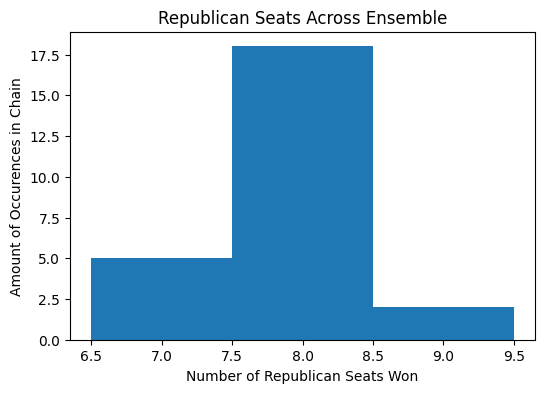

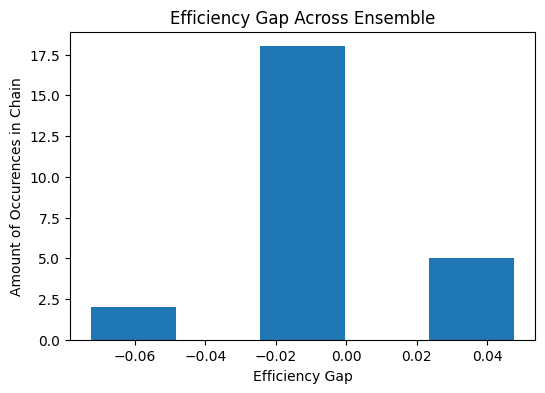

In [ ]:
# Create the list for the figures to display
# Figure for republican seats won
# Set the range of bins to be dynamic since number of seats is small in this case
plt.figure(figsize=(6,4))
plt.hist(rep_wins_list,
         bins=range(min(rep_wins_list), max(rep_wins_list)+2),
         align="left")
plt.title("Republican Seats Across Ensemble")
plt.xlabel("Number of Republican Seats Won")
plt.ylabel("Amount of Occurences in Chain")

plt.show()

# Figure for efficiency gap
# Use a fixed amount of bins in this case since efficiency gap varies alot
plt.figure(figsize=(6,4))
plt.hist(efficiency_gap_list, bins=5)
plt.title("Efficiency Gap Across Ensemble")
plt.xlabel("Efficiency Gap")
plt.ylabel("Amount of Occurences in Chain")

plt.show()